In [16]:
#import libraries
import pandas as pd
from xgboost import XGBClassifier as xgb
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import recall_score, precision_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV


In [ ]:
#import data
data = pd.read_csv('../../data/processed/cleaned_heart_data.csv')
data


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,M,TA,110,264,0,Normal,132,N,1.2,Flat,1
914,68,M,ASY,144,193,1,Normal,141,N,3.4,Flat,1
915,57,M,ASY,130,131,0,Normal,115,Y,1.2,Flat,1
916,57,F,ATA,130,236,0,LVH,174,N,0.0,Flat,1


In [18]:
#clean-up data
data_clean = data.loc[(data['Cholesterol'] != 0) & (data['RestingBP'] != 0)]
data_clean.info()


<class 'pandas.core.frame.DataFrame'>
Index: 746 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             746 non-null    int64  
 1   Sex             746 non-null    object 
 2   ChestPainType   746 non-null    object 
 3   RestingBP       746 non-null    int64  
 4   Cholesterol     746 non-null    int64  
 5   FastingBS       746 non-null    int64  
 6   RestingECG      746 non-null    object 
 7   MaxHR           746 non-null    int64  
 8   ExerciseAngina  746 non-null    object 
 9   Oldpeak         746 non-null    float64
 10  ST_Slope        746 non-null    object 
 11  HeartDisease    746 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 75.8+ KB


In [19]:
y = data_clean['HeartDisease']
X = data_clean.drop('HeartDisease', axis=1)

In [20]:
#Import libraries

import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import accuracy_score
import shap
import xgboost as xgb

In [21]:
# Split dataset into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [22]:
#baseline - 'Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBP', 'RestingECG'
#stress test - 'MaxHR', 'Oldpeak', 'ExerciseAngina', 'ST_Slope'

#Splitting the features into 2 scenarios. The first just the baseline data, the second using all features.

#Just baseline
X_train1 = X_train.drop(columns = ['MaxHR', 'Oldpeak', 'ExerciseAngina', 'ST_Slope'])    
X_test1 = X_test.drop(columns = ['MaxHR', 'Oldpeak', 'ExerciseAngina', 'ST_Slope'])        

#All data
X_train2 = X_train
X_test2 = X_test

In [23]:
#Define numerical and categorical features
num_features1 = ['Age', 'RestingBP', 'Cholesterol']
cat_features1 = ['Sex', 'ChestPainType', 'FastingBS', 'RestingECG']   

num_features2 = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']
cat_features2 = ['Sex', 'ChestPainType', 'FastingBS', 'RestingECG', 'ExerciseAngina', 'ST_Slope']   


In [24]:
#XGBoost Experiment using Gridsearch
#Just using baseline data

# Preprocessing for numerical data
numerical_transformer = StandardScaler()

# Preprocessing for categorical data
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Combine preprocessors into a column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, num_features1),
        ('cat', categorical_transformer, cat_features1)
    ])

# Define the XGBoost classifier
xgb = xgb.XGBClassifier(eval_metric='logloss', random_state=42)

# Create a pipeline that combines preprocessing with the classifier
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', xgb)
])

# Define the parameter grid for GridSearchCV
param_grid = {
    'classifier__n_estimators': [50, 100, 150, 200],
    'classifier__max_depth': [3, 5, 7],
    'classifier__learning_rate': [.005, 0.01, 0.1, 0.2],
    'classifier__subsample': [0.6, 0.8, 1.0],
    'classifier__colsample_bytree': [0.8, 1.0]
}

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid,
                           cv=5, n_jobs=-1, scoring='accuracy', verbose=1)

# Fit GridSearchCV
grid_search.fit(X_train1, y_train)

# Print the best parameters and best score
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation accuracy: ", grid_search.best_score_)

# Evaluate the best model on the test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test1)
test_accuracy = accuracy_score(y_test, y_pred)
test_recall = recall_score(y_test, y_pred)
print("Test accuracy: ", test_accuracy)
print("Test recall: ", test_recall)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits
Best parameters found:  {'classifier__colsample_bytree': 1.0, 'classifier__learning_rate': 0.01, 'classifier__max_depth': 3, 'classifier__n_estimators': 50, 'classifier__subsample': 0.6}
Best cross-validation accuracy:  0.7718347338935574
Test accuracy:  0.8133333333333334
Test recall:  0.7721518987341772


In [25]:
results = pd.DataFrame(grid_search.cv_results_)
sorted_results = results.sort_values(by='rank_test_score', ascending=True)
sorted_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__colsample_bytree,param_classifier__learning_rate,param_classifier__max_depth,param_classifier__n_estimators,param_classifier__subsample,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
180,0.030853,0.008055,0.003663,0.001791,1.0,0.010,3,50,0.6,"{'classifier__colsample_bytree': 1.0, 'classif...",0.758333,0.773109,0.823529,0.739496,0.764706,0.771835,0.028117,1
218,0.024587,0.009292,0.003949,0.001060,1.0,0.100,3,50,1.0,"{'classifier__colsample_bytree': 1.0, 'classif...",0.741667,0.764706,0.798319,0.756303,0.789916,0.770182,0.021057,2
58,0.104219,0.012034,0.007072,0.000904,0.8,0.010,5,200,0.8,"{'classifier__colsample_bytree': 0.8, 'classif...",0.750000,0.764706,0.815126,0.756303,0.756303,0.768487,0.023783,3
151,0.049914,0.015585,0.004256,0.002405,1.0,0.005,3,150,0.8,"{'classifier__colsample_bytree': 1.0, 'classif...",0.758333,0.756303,0.823529,0.739496,0.764706,0.768473,0.028761,4
69,0.069739,0.017445,0.004841,0.002254,0.8,0.010,7,200,0.6,"{'classifier__colsample_bytree': 0.8, 'classif...",0.758333,0.747899,0.823529,0.764706,0.747899,0.768473,0.028266,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26,0.026755,0.005938,0.004333,0.001249,0.8,0.005,7,50,1.0,"{'classifier__colsample_bytree': 0.8, 'classif...",0.700000,0.689076,0.731092,0.722689,0.697479,0.708067,0.016011,284
119,0.039731,0.010142,0.003655,0.001057,0.8,0.200,3,200,1.0,"{'classifier__colsample_bytree': 0.8, 'classif...",0.708333,0.714286,0.697479,0.689076,0.731092,0.708053,0.014434,285
169,0.034148,0.004049,0.005502,0.001704,1.0,0.005,7,50,0.8,"{'classifier__colsample_bytree': 1.0, 'classif...",0.700000,0.647059,0.747899,0.722689,0.714286,0.706387,0.033502,286
24,0.028095,0.006374,0.005284,0.002911,0.8,0.005,7,50,0.6,"{'classifier__colsample_bytree': 0.8, 'classif...",0.700000,0.680672,0.714286,0.705882,0.722689,0.704706,0.014257,287


In [27]:
#XGBoost Experiment using Gridsearch
#Using all features

# Preprocessing for numerical data
numerical_transformer = StandardScaler()

# Preprocessing for categorical data
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Combine preprocessors into a column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, num_features2),
        ('cat', categorical_transformer, cat_features2)
    ])

# Define the XGBoost classifier
xgb = XGBClassifier(eval_metric='logloss', random_state=42)

# Create a pipeline that combines preprocessing with the classifier
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', xgb)
])

# Define the parameter grid for GridSearchCV
param_grid = {
    'classifier__n_estimators': [50, 100, 150, 200],
    'classifier__max_depth': [3, 5, 7],
    'classifier__learning_rate': [.005, 0.01, 0.1, 0.2], 
    'classifier__subsample': [0.6, 0.8, 1.0], 
    'classifier__colsample_bytree': [0.8, 1.0] 
}

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid,
                           cv=5, n_jobs=-1, scoring='accuracy', verbose=1)

# Fit GridSearchCV
grid_search.fit(X_train2, y_train)

# Print the best parameters and best score
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation accuracy: ", grid_search.best_score_)

# Evaluate the best model on the test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test2)
test_accuracy = accuracy_score(y_test, y_pred)
test_recall = recall_score(y_test, y_pred)
print("Test accuracy: ", test_accuracy)
print("Test recall: ", test_recall)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits
Best parameters found:  {'classifier__colsample_bytree': 0.8, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 5, 'classifier__n_estimators': 50, 'classifier__subsample': 0.8}
Best cross-validation accuracy:  0.8641456582633055
Test accuracy:  0.92
Test recall:  0.8987341772151899


In [28]:
results = pd.DataFrame(grid_search.cv_results_)
sorted_results = results.sort_values(by='rank_test_score', ascending=True)
sorted_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__colsample_bytree,param_classifier__learning_rate,param_classifier__max_depth,param_classifier__n_estimators,param_classifier__subsample,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
85,0.021755,0.008208,0.003912,0.001438,0.8,0.100,5,50,0.8,"{'classifier__colsample_bytree': 0.8, 'classif...",0.833333,0.865546,0.890756,0.848739,0.882353,0.864146,0.021111,1
252,0.019882,0.006373,0.003729,0.001455,1.0,0.200,3,50,0.6,"{'classifier__colsample_bytree': 1.0, 'classif...",0.858333,0.882353,0.882353,0.823529,0.865546,0.862423,0.021604,2
220,0.035058,0.008068,0.003668,0.002387,1.0,0.100,3,100,0.8,"{'classifier__colsample_bytree': 1.0, 'classif...",0.858333,0.873950,0.873950,0.823529,0.882353,0.862423,0.020940,2
84,0.023699,0.006798,0.004974,0.002180,0.8,0.100,5,50,0.6,"{'classifier__colsample_bytree': 0.8, 'classif...",0.841667,0.890756,0.865546,0.831933,0.873950,0.860770,0.021411,4
74,0.027972,0.015477,0.004760,0.003032,0.8,0.100,3,50,1.0,"{'classifier__colsample_bytree': 0.8, 'classif...",0.858333,0.865546,0.890756,0.831933,0.857143,0.860742,0.018829,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144,0.022855,0.007004,0.003838,0.001657,1.0,0.005,3,50,0.6,"{'classifier__colsample_bytree': 1.0, 'classif...",0.825000,0.831933,0.831933,0.798319,0.848739,0.827185,0.016418,283
2,0.021311,0.008285,0.004239,0.001418,0.8,0.005,3,50,1.0,"{'classifier__colsample_bytree': 0.8, 'classif...",0.841667,0.840336,0.840336,0.781513,0.831933,0.827157,0.023083,285
26,0.042908,0.011321,0.005666,0.002878,0.8,0.005,7,50,1.0,"{'classifier__colsample_bytree': 0.8, 'classif...",0.833333,0.848739,0.806723,0.806723,0.831933,0.825490,0.016419,286
170,0.040995,0.006930,0.002761,0.000331,1.0,0.005,7,50,1.0,"{'classifier__colsample_bytree': 1.0, 'classif...",0.816667,0.815126,0.806723,0.798319,0.823529,0.812073,0.008712,287


[19:59:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.



Accuracy: 0.92
Test recall: 0.89


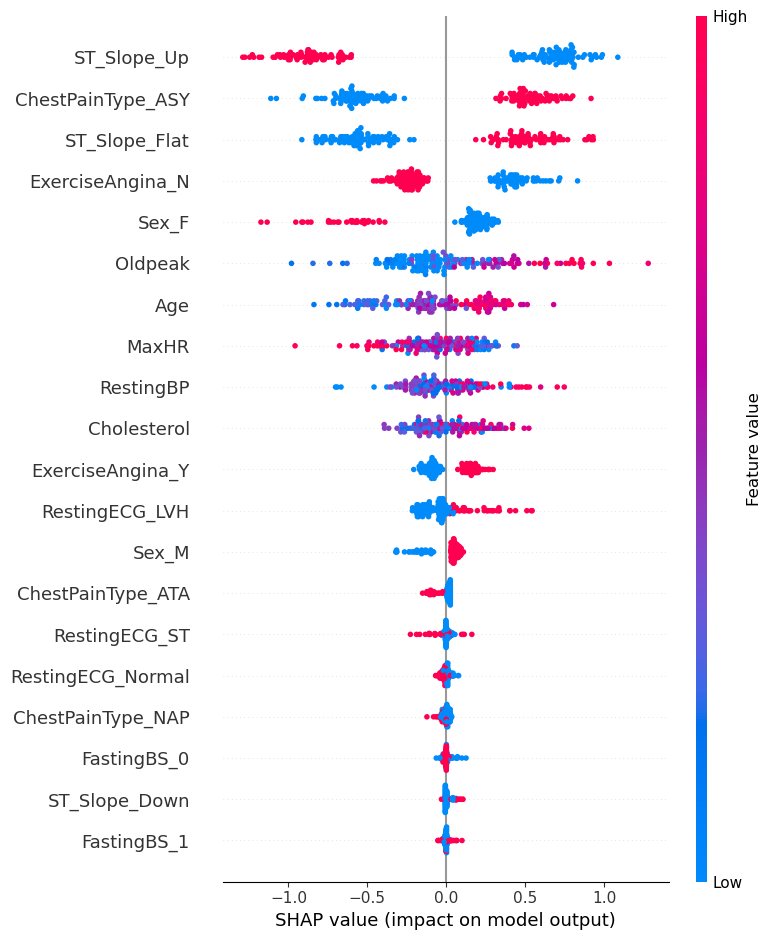

In [31]:
#Using best parameters, generate SHAP plot

# Create a column transformer that applies OneHotEncoder to categorical features
# and StandardScaler to numerical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_features2),
        ('cat', OneHotEncoder(), cat_features2)
    ])

# Create a pipeline that first applies the preprocessor and then fits the XGBClassifier
b_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(
        use_label_encoder=False,
        eval_metric='logloss',
        colsample_bytree=0.8,
        learning_rate=0.1,
        max_depth=5,
        n_estimators=50,
        subsample=0.8
    ))
])


# Train the model using the pipeline
b_model.fit(X_train2, y_train)

# Make predictions
y_pred = b_model.predict(X_test2)

# Evaluate accuracy and recall
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print(f"Test recall: {recall:.2f}")

# SHAP explanation
# Get the model from the pipeline (XGBClassifier)
xgb_model = b_model.named_steps['classifier']

# Use TreeExplainer to get SHAP values
explainer = shap.TreeExplainer(xgb_model)

# The preprocessor is applied in the pipeline, so we need to transform the data before passing it to SHAP
X_test_transformed = b_model.named_steps['preprocessor'].transform(X_test2)

# Compute SHAP values for the test set
shap_values = explainer.shap_values(X_test_transformed)

# Visualize SHAP values
shap.summary_plot(shap_values, X_test_transformed, feature_names=num_features2 + list(model.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out()))

In [32]:
#Save bext model as pickle file
import pickle

with open('xgboost_model.pkl', 'wb') as f:
    pickle.dump(b_model, f)
